In [2]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
from scipy.signal import savgol_filter
#import celerite
#from celerite import terms

### 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

Metadata

In [3]:
import pandas as pd

filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [4]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

Download light curve from MAST

In [5]:
flc = lightkurve.search_lightcurve("EPIC 246301900", cadence="long", campaign=12, mission="K2")
print(flc)

HTTPError: 404 Client Error: Not Found for url: https://mast.stsci.edu/portal/Mashup/Mashup.asmx/columnsconfig

In [ ]:
download = flc[2].download()

In [ ]:
plt.scatter(download.time.value, download.flux.value, s=2)
plt.show()

In [ ]:
plt.scatter(df.TIME, df.PDCSAP_FLUX, s=2)
plt.show()

In [ ]:
# examine the gap
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2935,2985])
plt.ylim([590000,700000])
plt.show()

In [ ]:
# examine spike/possible flare shortly after 2970 BJD
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2971,2973])
plt.ylim([590000,700000])
plt.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)

3255


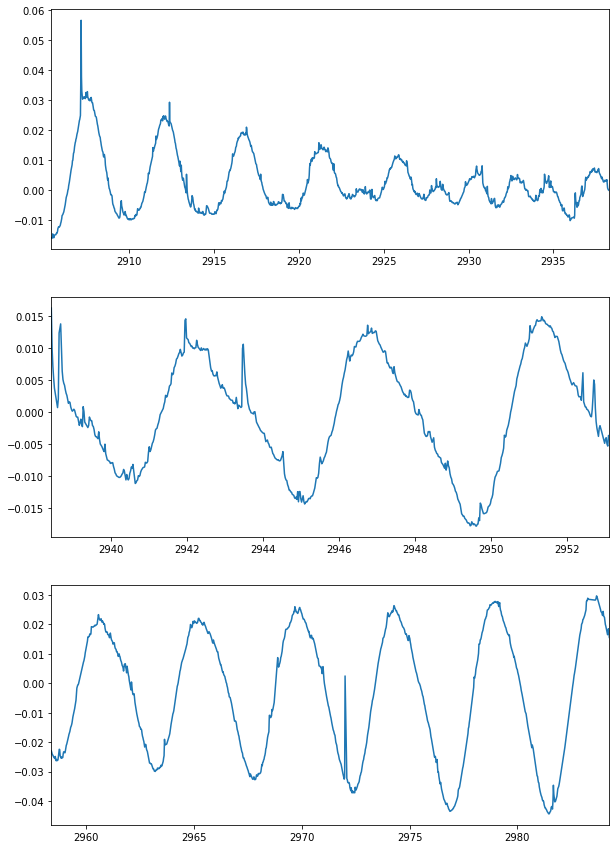

In [6]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) GP Modeling

Model with GP in order to get a baby-smooth light curve on which I can inject artificial flares for injection recovery.

Pre-super-flare

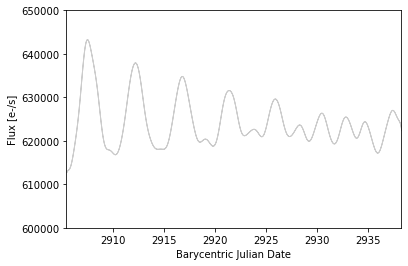

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612843.0178797  612963.33290786 613059.09891857 ... 623112.17550293
 622799.29855908 622437.74863554]


In [7]:
lhs_pre = min(pre.TIME)
rhs_pre = max(pre.TIME)
xobs_pre = np.array(pre["TIME"])
yobs_pre = np.array(pre["PDCSAP_FLUX"])
eobs_pre = np.array(pre["PDCSAP_FLUX_ERR"])

kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.8)
gp_pre = george.GP(kernel_pre)
gp_pre.compute(xobs_pre, eobs_pre)

pred_pre, pred_var_pre = gp_pre.predict(yobs_pre, xobs_pre, return_var=True)

plt.fill_between(xobs_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre),
                color="k", alpha=0.2)
#plt.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
plt.xlim(lhs_pre, rhs_pre)
#plt.xlim(lhs,2910)
plt.ylim(600000,650000)
plt.xlabel(r'Barycentric Julian Date')
plt.ylabel(r'Flux [e-/s]')
#plt.scatter(xobs_pre, yobs_pre, s=2)
plt.show()

print(yobs_pre)
print(pred_pre)

Same for post and postgap

In [22]:
def alias(df, normalized_flag, method, segment):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    - method: 'gp' or 'savgol'
    - segment: 'pre', 'post', or 'postgap' (really only needed for savgol)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["PDCSAP_FLUX"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.5) # 0.8
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        if method=='gp':
            pred, pred_var = gp.predict(yobs, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs, 129, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs, 129, polyorder=3)
            return pred
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        if method=='gp':
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs_norm, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs_norm, 149, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs_norm, 129, polyorder=3)
            return pred

#pred_pre, pred_var_pre = alias(pre, normalized_flag=True, method='gp', segment='pre')
#pred_post, pred_var_post = alias(post, normalized_flag=True, method='gp', segment='post')
pred_pre = alias(pre, normalized_flag=True, method='savgol', segment='pre')
pred_post = alias(post, normalized_flag=True, method='savgol', segment='post')
pred_postgap, pred_var_postgap = alias(postgap, normalized_flag=True, method='gp', segment='postgap')


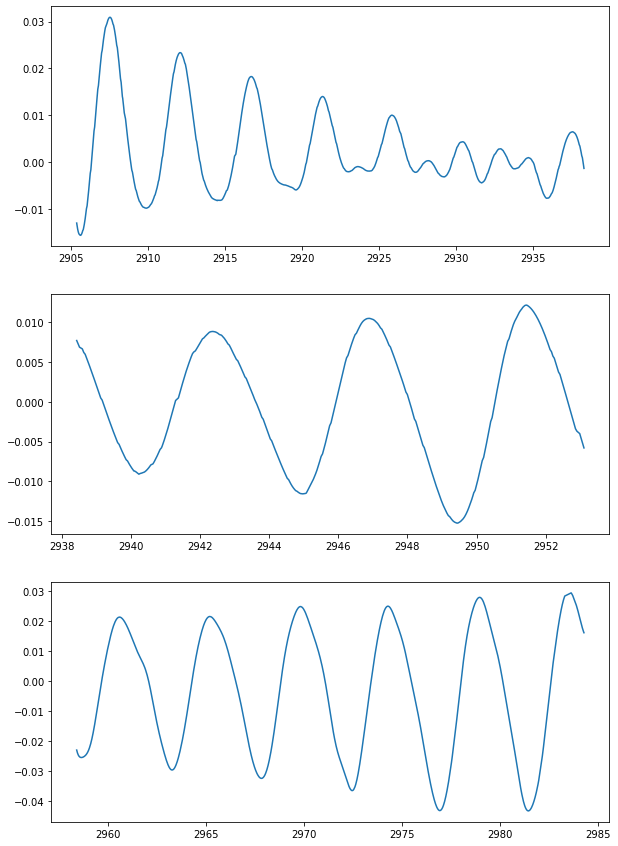

In [23]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, pred_pre)

plt.subplot(312)
plt.plot(post.TIME, pred_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

### 3) Inject flares

Pieces taken from Ekaterina Ilin's Altaipony: https://github.com/ekaterinailin/AltaiPony/blob/037bd76c8ed09ed6340cf2105d1e83bc302168eb/altaipony/flarelc.py

In [12]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    #error = error # pred_var_pre
    flux = flux # pred_pre
    time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed)
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

dur_fake_pre, ampl_fake_pre, t0_fake_pre, ed_fake_pre, flux_pre = inject_fakes(pred_pre, pre, num_flares=20)
dur_fake_post, ampl_fake_post, t0_fake_post, ed_fake_post, flux_post = inject_fakes(pred_post, post, num_flares=10)
dur_fake_postgap, ampl_fake_postgap, t0_fake_postgap, ed_fake_postgap, flux_postgap = inject_fakes(pred_postgap, postgap, num_flares=20)


In [24]:
ampl_fake_pre

array([1.76506275, 4.34312481, 0.31058113, 4.37079392, 0.72802784,
       4.97926056, 4.43328219, 1.2042977 , 2.1368521 , 2.19542801,
       0.31636662, 4.20555614, 1.87352749, 4.26940502, 1.43260426,
       4.07247734, 2.95433166, 1.16229358, 2.45785955, 2.70752818])

In [46]:
print(dur_fake_pre)
print(ampl_fake_pre)
print(t0_fake_pre)
print(ed_fake_pre)
print(flux_pre)

[0.00659214 0.01157305 0.0074986  0.0090699  0.00837626 0.0102298
 0.0087358  0.00861535 0.00789017 0.00983356 0.00835018 0.00549055
 0.01149266 0.00659056 0.00851488 0.01031487 0.00928937 0.0116697
 0.00993538 0.01045548]
[2.79238804 4.93915924 3.42396883 1.22894263 4.64707022 3.86687512
 4.84898104 1.83003265 1.39376658 1.67876576 2.59003945 0.92607348
 1.14549473 3.86823962 0.0581391  2.39583373 0.36691504 0.07152127
 0.87613026 1.05042589]
[2935.29043723 2916.32315062 2938.28889561 2910.49590012 2912.76122356
 2929.45365177 2917.0128284  2927.65378342 2912.07794362 2914.87614056
 2922.6067152  2924.63927118 2917.6591169  2907.60794693 2928.00340437
 2913.75140515 2914.83160547 2912.76386473 2926.52570784 2915.55317585]
[2912.62686704 4450.69048696    0.          550.29385132 1510.35179589
 1610.77305881 1985.98580481  523.36606066 2015.20169787 2217.15706538
  687.84298957  377.45190744 1096.10994407  608.76118167   19.28971532
 2774.13637973  259.61883585   44.3675327  1019.906949

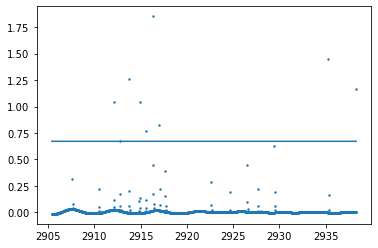

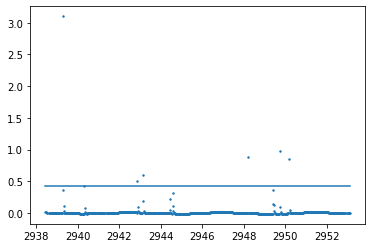

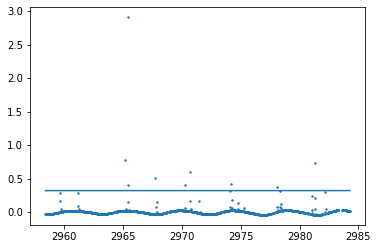

In [47]:
### did I do it?
plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, np.ones(len(pre))*np.median(flux_pre)+7*np.std(flux_pre))
#plt.xlim(2908, 2911)
plt.show()

plt.scatter(post.TIME, flux_post, s=2)
plt.plot(post.TIME, np.ones(len(post))*np.median(flux_post)+3*np.std(flux_post))
plt.show()

plt.scatter(postgap.TIME, flux_postgap, s=2)
plt.plot(postgap.TIME, np.ones(len(postgap))*np.median(flux_postgap)+3*np.std(flux_postgap))
plt.show()
### yes I did!

### 4) Recover fake flares

In [31]:
print(np.abs(flux_pre))
print(np.abs(flux_pre) / np.sqrt(pred_var_pre))
print(np.abs(flux_pre) / pred_var_pre)
print(np.median(flux_pre))
print(np.median(flux_pre)+3*np.std(flux_pre))

[0.01298546 0.0134594  0.01388325 ... 0.00035522 0.00083043 0.00132385]
[9.75379496e-04 1.24952424e-03 1.55732682e-03 ... 3.84930492e-05
 7.47104822e-05 9.66678348e-05]
[7.32639020e-05 1.16001539e-04 1.74690080e-04 ... 4.17128225e-06
 6.72143950e-06 7.05871144e-06]
0.0004572143079712987
0.29430155034933725


In [32]:
flux = flux_pre
var = pred_var_pre
#var = pre.PDCSAP_FLUX_ERR
T0 = flux # excursion should be positive #"N0"
T1 = np.abs(flux) / np.std(flux) #N1
T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
print("T1: ", T1)
print("T2: ", T2)
minsep = 3
N1 = 7
N2 = 3
N3 = 1
istart = np.array([], dtype='int')
istop = np.array([], dtype='int')

pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
print("pass thresholds: ", pass_thresholds)

#array of indices where thresholds are exceeded:
is_pass_thresholds = np.zeros_like(flux)
is_pass_thresholds[pass_thresholds] = 1

# test based on consecutive points
reverse_counts = np.zeros_like(flux, dtype='int')
for k in range(2, len(flux)):
    reverse_counts[-k] = (is_pass_thresholds[-k]
                            * (reverse_counts[-(k-1)]
                            + is_pass_thresholds[-k]))

# find flare start where values in reverse_counts switch from 0 to >=N3
istart_i = np.where((reverse_counts[1:] >= N3) &
                    (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

# use the value of reverse_counts to determine how many points away stop is
istop_i = istart_i + (reverse_counts[istart_i])

# Create boolean flare mask
isflare = np.zeros_like(flux, dtype='bool')

for (l,r) in list(zip(istart_i, istop_i)):
    isflare[l:r+1] = True
    
print("is flare? ", isflare)

### 

# now pick out final flare candidate indices
candidates = np.where( isflare > 0)[0]
print("candidates: ", candidates)
if (len(candidates) < 1): # no candidates = no indices
    istart_gap = np.array([])
    istop_gap = np.array([])
else:
    # find start and stop index, combine neighboring candidates
    # in to same events
    separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
    istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
    istop_gap = candidates[ np.append(separated_candidates,
                            [len(candidates) - 1]) ]

print(istart_gap)
print(istop_gap)
#stitch indices back into the original light curve
#istart = np.array(np.append(istart, istart_gap + le), dtype='int')
#istop = np.array(np.append(istop, istop_gap + le), dtype='int')

print(len(istart_gap))

T1:  [0.13257485 0.13741355 0.14174091 ... 0.00362659 0.00847822 0.01351582]
T2:  [136.05387097 110.11010787  91.15726018 ...  94.21789236 113.48948394
 139.83068143]
pass thresholds:  (array([   5,  564,  814,  866,  974, 1132, 1169]),)
is flare?  [False False False ... False False False]
candidates:  [   5    6  564  565  814  815  866  867  974  975 1132 1133 1169 1170]
[   5  564  814  866  974 1132 1169]
[   6  565  815  867  975 1133 1170]
7


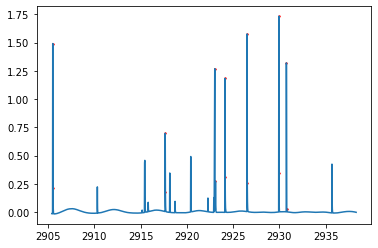

In [33]:
#for xc in pre.TIME[istart_gap]:
#    plt.axvline(x=xc, c='r')
#for xc in t0_fake_pre:
#    plt.axvline(x=xc, c='r', linestyle='--')
#plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, flux_pre)
#plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

### 5) Evaluate recovery

Compare istart_gaps and t0s to calculate TPs, FPs, and FNs. 

In [34]:
print(istart_gap)
print(np.array(pre.TIME)[istart_gap])

[   5  564  814  866  974 1132 1169]
[2905.49982382 2917.65693963 2923.0101023  2924.11342214 2926.50394478
 2929.93648107 2930.75375031]


In [35]:
t0_fake_pre

array([2910.31173854, 2917.64565416, 2918.71240096, 2930.74957005,
       2915.80279866, 2923.00308374, 2924.1054664 , 2923.08370805,
       2915.64699034, 2929.94409755, 2922.26995687, 2929.93393259,
       2935.66951208, 2918.13182685, 2915.1275698 , 2915.43278652,
       2920.40536525, 2922.89337633, 2905.50076891, 2926.50128127])

In [36]:
pred_flares_pre = pd.DataFrame({'istart': np.array(pre.TIME)[istart_gap], 
                                'istop': np.array(pre.TIME)[istop_gap],
                               'gap': np.array(pre.TIME)[istop_gap]-np.array(pre.TIME)[istart_gap]})
print(pred_flares_pre)

tps = 0
for i in t0_fake_pre:
    # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
    if (np.abs(i - pred_flares_pre['istart']) < np.max(pred_flares_pre['gap'])).any():
        tps += 1
fps = len(istart_gap) - tps      
fns = len(t0_fake_pre) - tps
print("TPs: ", tps)
print("FPs: ", fps)
print("FNs: ", fns)

        istart        istop       gap
0  2905.499824  2905.520256  0.020432
1  2917.656940  2917.677372  0.020432
2  2923.010102  2923.030534  0.020432
3  2924.113422  2924.133854  0.020432
4  2926.503945  2926.524377  0.020432
5  2929.936481  2929.956913  0.020432
6  2930.753750  2930.794614  0.040863
TPs:  8
FPs:  -1
FNs:  12


In [37]:
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)))
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR))
print(np.std(pre.PDCSAP_FLUX))
print(np.median(pre.PDCSAP_FLUX))
print(pred_pre)
print(pred_var_pre)

1        9925.3750
2        9947.8125
3       10015.8125
4        9865.2500
5        9091.9375
           ...    
1607      292.0625
1608       66.0000
1609       70.1250
1610       30.4375
1611       96.1875
Name: PDCSAP_FLUX, Length: 1511, dtype: float32
1        9947.728516
2        9970.178711
3       10038.190430
4        9887.641602
5        9114.365234
            ...     
1607      269.120148
1608       43.062344
1609       47.187157
1610       53.378136
1611      119.137451
Length: 1511, dtype: float32
5889.1313
622840.6
[-0.01298546 -0.0134594  -0.01388325 ... -0.00035522 -0.00083043
 -0.00132385]
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]


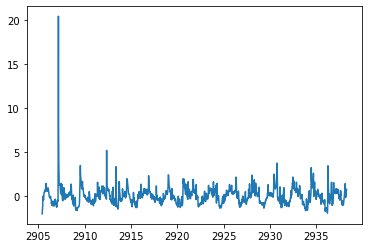

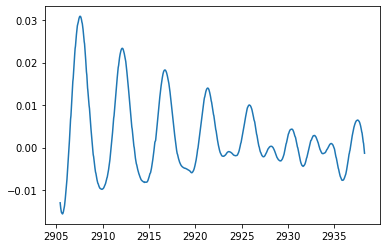

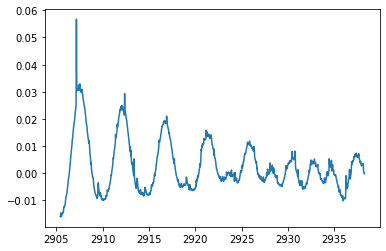

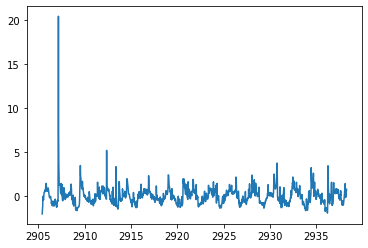

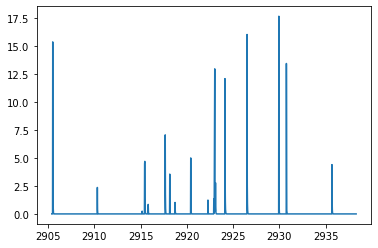

17.680548809073276


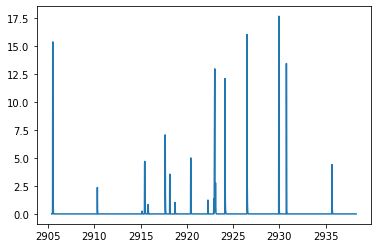

17.680170955571253


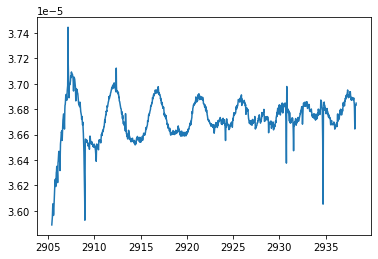

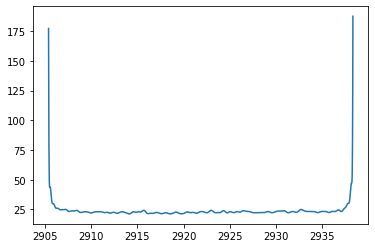

In [38]:
"""
plt.plot(pre.TIME, pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, (pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1)/np.std(pre.PDCSAP_FLUX))
plt.show()
"""

### what I end up using
# data detrended
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

plt.plot(pre.TIME, pred_pre)
plt.show()

plt.plot(pre.TIME, norm_flux_pre)
plt.show()

# data detrended minus error, with detrending propagated
plt.plot(pre.TIME, (norm_flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(norm_flux_pre-pred_pre))
plt.show()

# GP model detrended
plt.plot(pre.TIME, (flux_pre-pred_pre)/np.std(flux_pre-pred_pre))
plt.show()
print(np.max((flux_pre-pred_pre)/np.std(flux_pre-pred_pre)))

# GP model detrended minus error, with detrending propagated
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))
plt.show()
print(np.max((flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))))

# data error with detrending propagated
plt.plot(pre.TIME, pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))
plt.show()

# GP model variance
plt.plot(pre.TIME, pred_var_pre)
plt.show()


Functionalize everything

In [39]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap

def analyze_recovery(df, t0_fake, istart_gap, istop_gap):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - df: original DataFrame cut into pre/post/postgap/whatever
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - istart_gap: one of the outputs of recover_flares(); all the flare start time indices
    - istop_gap: one of the outputs of recover_flares(); all the flare stop time indices
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    try:
        pred_flares = pd.DataFrame({'istart': np.array(df.TIME)[istart_gap], 
                                    'istop': np.array(df.TIME)[istop_gap],
                                   'gap': np.array(df.TIME)[istop_gap]-np.array(df.TIME)[istart_gap]})
    except:
        print("no true positives")
        return 
    
    tps = 0
    for i in t0_fake:
        # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
        if (np.abs(i - pred_flares['istart']) < np.max(pred_flares['gap'])).any():
            tps += 1
    
    fps = np.abs(len(istart_gap) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.7
N2 = 1.7
N3 = 1
norm_var_pre = pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX) # propagate error through normalization

#candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(flux_pre, pred_var_pre, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_post, istart_gap_post, istop_gap_post = recover_flares(flux_post, pred_var_post, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(flux_postgap, pred_var_postgap, N1=N1, N2=N2, N3=N3, minsep=3)
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)

print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))

"""
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))
"""

(14, 2, 6)
(9, 2, 1)
(15, 1, 5)


'\ncandidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\nprint(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))\nprint(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))\nprint(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))\n'

In [40]:
print(pre.PDCSAP_FLUX_ERR)
print(pred_var_pre)
print(pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX_ERR) - 1)
print(pred_var_pre/np.median(pred_var_pre) - 1)
print((pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))**2)
#properly normalize this!!!

1       22.353420
2       22.366695
3       22.378389
4       22.391329
5       22.427473
          ...    
1607    22.942354
1608    22.937656
1609    22.937845
1610    22.940638
1611    22.949953
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]
1      -0.022793
2      -0.022212
3      -0.021701
4      -0.021135
5      -0.019555
          ...   
1607    0.002953
1608    0.002748
1609    0.002756
1610    0.002878
1611    0.003286
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[6.7620043  4.08122698 2.48040487 ... 2.7293419  4.41059737 7.21334096]
1       1.288054e-09
2       1.289584e-09
3       1.290933e-09
4       1.292427e-09
5       1.296602e-09
            ...     
1607    1.356819e-09
1608    1.356264e-09
1609    1.356286e-09
1610    1.356617e-09
1611    1.357718e-09
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32


So our flare identification threshold is {1.7, 1.7, 1}.

### 6) Flare identification: Altaipony

In [41]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
norm_flux_post = post.PDCSAP_FLUX/np.median(post.PDCSAP_FLUX) - 1 
norm_flux_postgap = postgap.PDCSAP_FLUX/np.median(postgap.PDCSAP_FLUX) - 1 
N1 = 1.7
N2 = 1.7
N3 = 2

candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, norm_flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, norm_flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, norm_flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
print(len(istart_gap_pre))
print(len(istart_gap_post))
print(len(istart_gap_postgap))
print(istart_gap_pre)
print(istart_gap_post)
print(istart_gap_postgap)

12
4
5
[  78  184  420  528  630  708  756 1155 1168 1335 1346 1417]
[  7 157 225 654]
[ 17 229 440 547 990]


Check how predictions match up

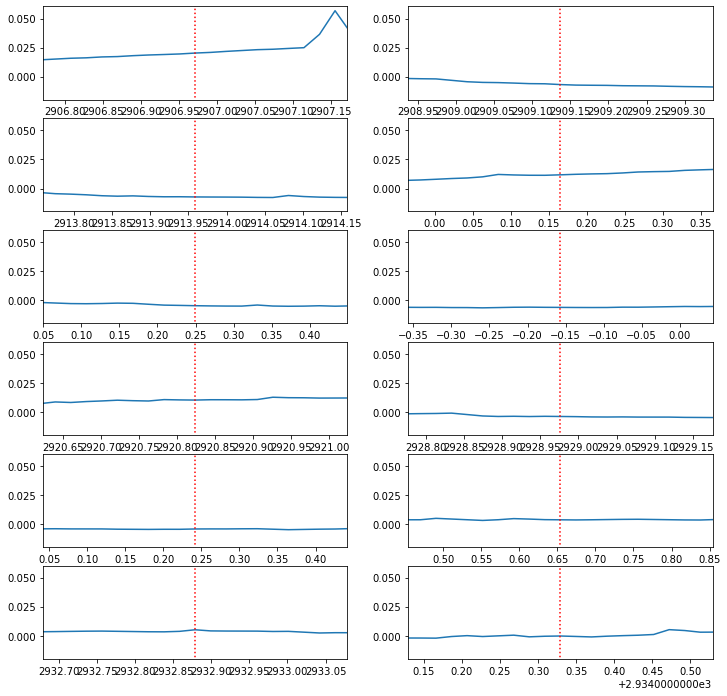

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(istart_gap_pre)/2).astype(int), figsize=[12,len(istart_gap_pre)])
axes = axes.flatten()
for i in range(len(istart_gap_pre)):
    ax = axes[i]
    ax.plot(pre.TIME, norm_flux_pre)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(pre.TIME[istart_gap_pre[i]], -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

Uh...not good. 

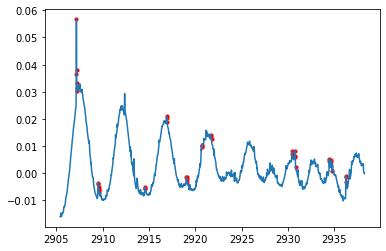

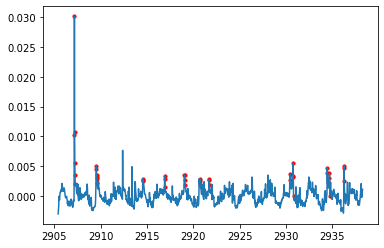

In [43]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

plt.plot(pre.TIME, norm_flux_pre-pred_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre-pred_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()



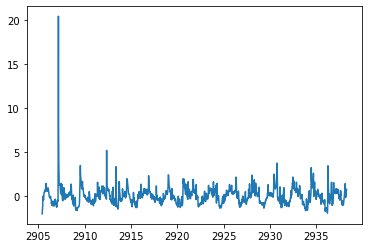

In [44]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

Amend recover_flares() to also return pass_thresholds. So it seems that legitimate flares get thrown out during the N3 check.

In [45]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap, pass_thresholds

candidates_pre, istart_gap_pre, istop_gap_pre, pass_thresholds_pre = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post, pass_thresholds_post = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap, pass_thresholds_postgap = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)


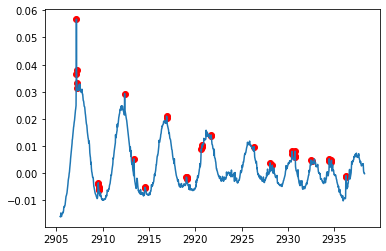

In [46]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[pass_thresholds_pre], np.array(norm_flux_pre)[pass_thresholds_pre], c='r')

Instead of GPs, how about savgol?

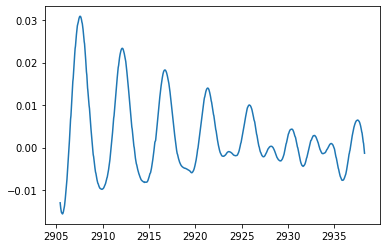

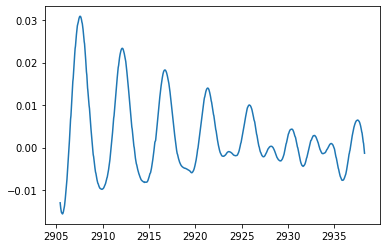

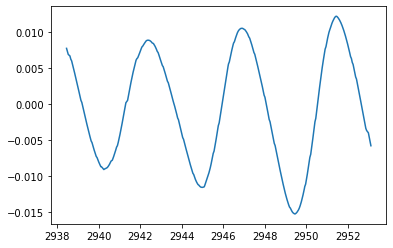

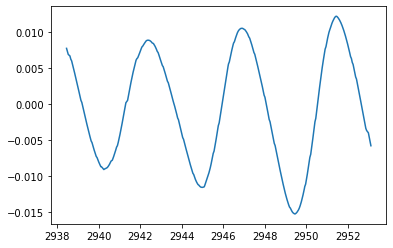

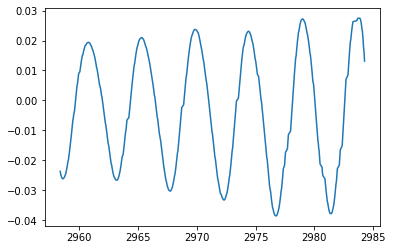

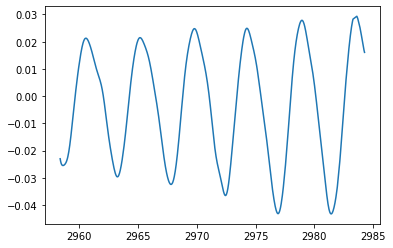

In [47]:
from scipy.signal import savgol_filter

def normalize_flux(flux):
    return flux/np.median(flux) - 1

norm_pre = normalize_flux(pre.PDCSAP_FLUX)
norm_post = normalize_flux(post.PDCSAP_FLUX)
norm_postgap = normalize_flux(postgap.PDCSAP_FLUX)

savgol_pre = savgol_filter(norm_pre, 109, polyorder=3)
savgol_post = savgol_filter(norm_post, 149, polyorder=3)
savgol_postgap = savgol_filter(norm_postgap, 129, polyorder=3)

plt.plot(pre.TIME, savgol_pre)
plt.show()

plt.plot(pre.TIME, pred_pre) # oops, was previously the GP model
plt.show()


plt.plot(post.TIME, savgol_post)
plt.show()

plt.plot(post.TIME, pred_post) # oops, was previously the GP model
plt.show()


plt.plot(postgap.TIME, savgol_postgap)
plt.show()

plt.plot(postgap.TIME, pred_postgap)
plt.show()

Looks like savgol has GPs beat for pre and post, but GP is a better detrending for postgap. So we'll use savgol_pre, savgol_post, and pred_postgap.

### 7) Flare recovery and identification: xoflares

I'm going to switch to xoflares because that already has fwhm calculations built in. The only thing I need to do is adapt it to allow for injection recovery.

In [123]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

def find_flares(lc, flux, pred, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - pred: GP-predicted spot modulation flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux # save this for ampls
    flux = (flux-pred)/np.std(flux-pred) # subtract out GP-modeled spot modulation flux
    mflare = (flux < N1) & (flux - lc.PDCSAP_FLUX_ERR/np.median(lc.PDCSAP_FLUX) < N2)
    
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([lc.TIME.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    print(len(tpeaks))
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.3
N2 = 1.3
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
_, _, tpeaks_pre, _, _, _, _, _ = find_flares(pre, flux_pre, savgol_pre, N1, N2)
_, _, tpeaks_post, _, _, _, _, _ = find_flares(post, flux_post, savgol_post, N1, N2)
_, _, tpeaks_postgap, _, _, _, _, _ = find_flares(postgap, flux_postgap, pred_postgap, N1, N2)

idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre, fps_pre, fns_pre = analyze_recovery_for_xoflares(tpeaks_pre, t0_fake_pre, tol=tol*idx_interval)
tps_post, fps_post, fns_post = analyze_recovery_for_xoflares(tpeaks_post, t0_fake_post, tol=tol*idx_interval)
tps_postgap, fps_postgap, fns_postgap = analyze_recovery_for_xoflares(tpeaks_postgap, 
                                                                      t0_fake_postgap, tol=tol*idx_interval)

print(tps_pre, fps_pre, fns_pre)
print(tps_post, fps_post, fns_post)
print(tps_postgap, fps_postgap, fns_postgap)


13
7
14
14 1 6
8 1 2
15 1 5


Note that my assessment of TPs is not perfect. For example, I've only predicted 16 flares in pre; yet, I have 18 TPs (another sign is that 16+2+2 is not 20). But most likely, pre is 16 TP, 0 FP, and 4 FN.

Okay, so savgol vs GP makes no difference with my light curve (toggle between first two and second two find_flares() runs in cell above).

Let's identify some real flares and hope they're finally right.

In [124]:
x_pre, y_pre, tpeaks_pre, tpeaks_norm_pre, ampls_pre, unnorm_ampls_pre, fwhms_pre, npeaks_pre = find_flares(pre, norm_flux_pre, 
                                                                                          savgol_pre, N1, N2)
x_post, y_post, tpeaks_post, tpeaks_norm_post, ampls_post, unnorm_ampls_post, fwhms_post, npeaks_post = find_flares(post, norm_flux_post, 
                                                                                          savgol_post, N1, N2)
x_postgap, y_postgap, tpeaks_postgap, tpeaks_norm_postgap, ampls_postgap, unnorm_ampls_postgap, fwhms_postgap, npeaks_postgap = find_flares(postgap,
                                                                        norm_flux_postgap, pred_postgap, N1, N2)
print(npeaks_pre, npeaks_post, npeaks_postgap)

48 16 23


In [125]:
print(len(x_pre), len(y_pre), len(tpeaks_pre), len(tpeaks_norm_pre), len(ampls_pre), len(fwhms_pre))
out_pre = pd.DataFrame({'tpeak': tpeaks_pre, 'tpeaks_norm': tpeaks_norm_pre, 'ampls': ampls_pre, 'unnorm_ampls': unnorm_ampls_pre, 'fwhms': fwhms_pre})
out_post = pd.DataFrame({'tpeak': tpeaks_post, 'tpeaks_norm': tpeaks_norm_post, 'ampls': ampls_post, 'unnorm_ampls': unnorm_ampls_post, 'fwhms': fwhms_post})
out_postgap = pd.DataFrame({'tpeak': tpeaks_postgap, 'tpeaks_norm': tpeaks_norm_postgap, 'ampls': ampls_postgap, 'unnorm_ampls': unnorm_ampls_postgap,
                            'fwhms': fwhms_postgap})
out = pd.concat([out_pre, out_post, out_postgap]).reset_index()
print(out)
print(out.loc[out.ampls>0])
#out.to_csv('identified_flares.csv', index=False)

1511 1511 48 48 48 48
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995     -0.012207  0.002778
1       1  2907.134405   -14.710944  6.983271      0.036412  0.009722
2       2  2907.297863   -14.547486  1.309872      0.030955  0.002778
3       3  2907.440889   -14.404460  1.451282      0.032603  0.002778
4       4  2907.522618   -14.322731  1.368187      0.032903  0.002778
..    ...          ...          ...       ...           ...       ...
82     18  2977.991542     6.670886  1.682145      0.002133  0.002778
83     19  2978.216291     6.895634  1.356167      0.013344  0.002778
84     20  2979.176580     7.855923  1.439159      0.027429  0.002778
85     21  2979.626077     8.305420  1.309828      0.016393  0.002778
86     22  2981.669248    10.348591  4.987364     -0.034611  0.004167

[87 rows x 6 columns]
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995

In [116]:
pred_pre_df = pd.DataFrame(savgol_pre, columns=['flux_norm'])
pred_post_df = pd.DataFrame(savgol_post, columns=['flux_norm'])
pred_postgap_df = pd.DataFrame(pred_postgap, columns=['flux_norm'])
pred_df = pd.concat([pred_pre_df, pred_post_df, pred_postgap_df])
print(pred_df)
pred_df.to_csv('preds.csv',index=False)

      flux_norm
0     -0.012985
1     -0.013459
2     -0.013883
3     -0.014258
4     -0.014585
...         ...
1066   0.018153
1067   0.017673
1068   0.016795
1069   0.016409
1070   0.016069

[3253 rows x 1 columns]


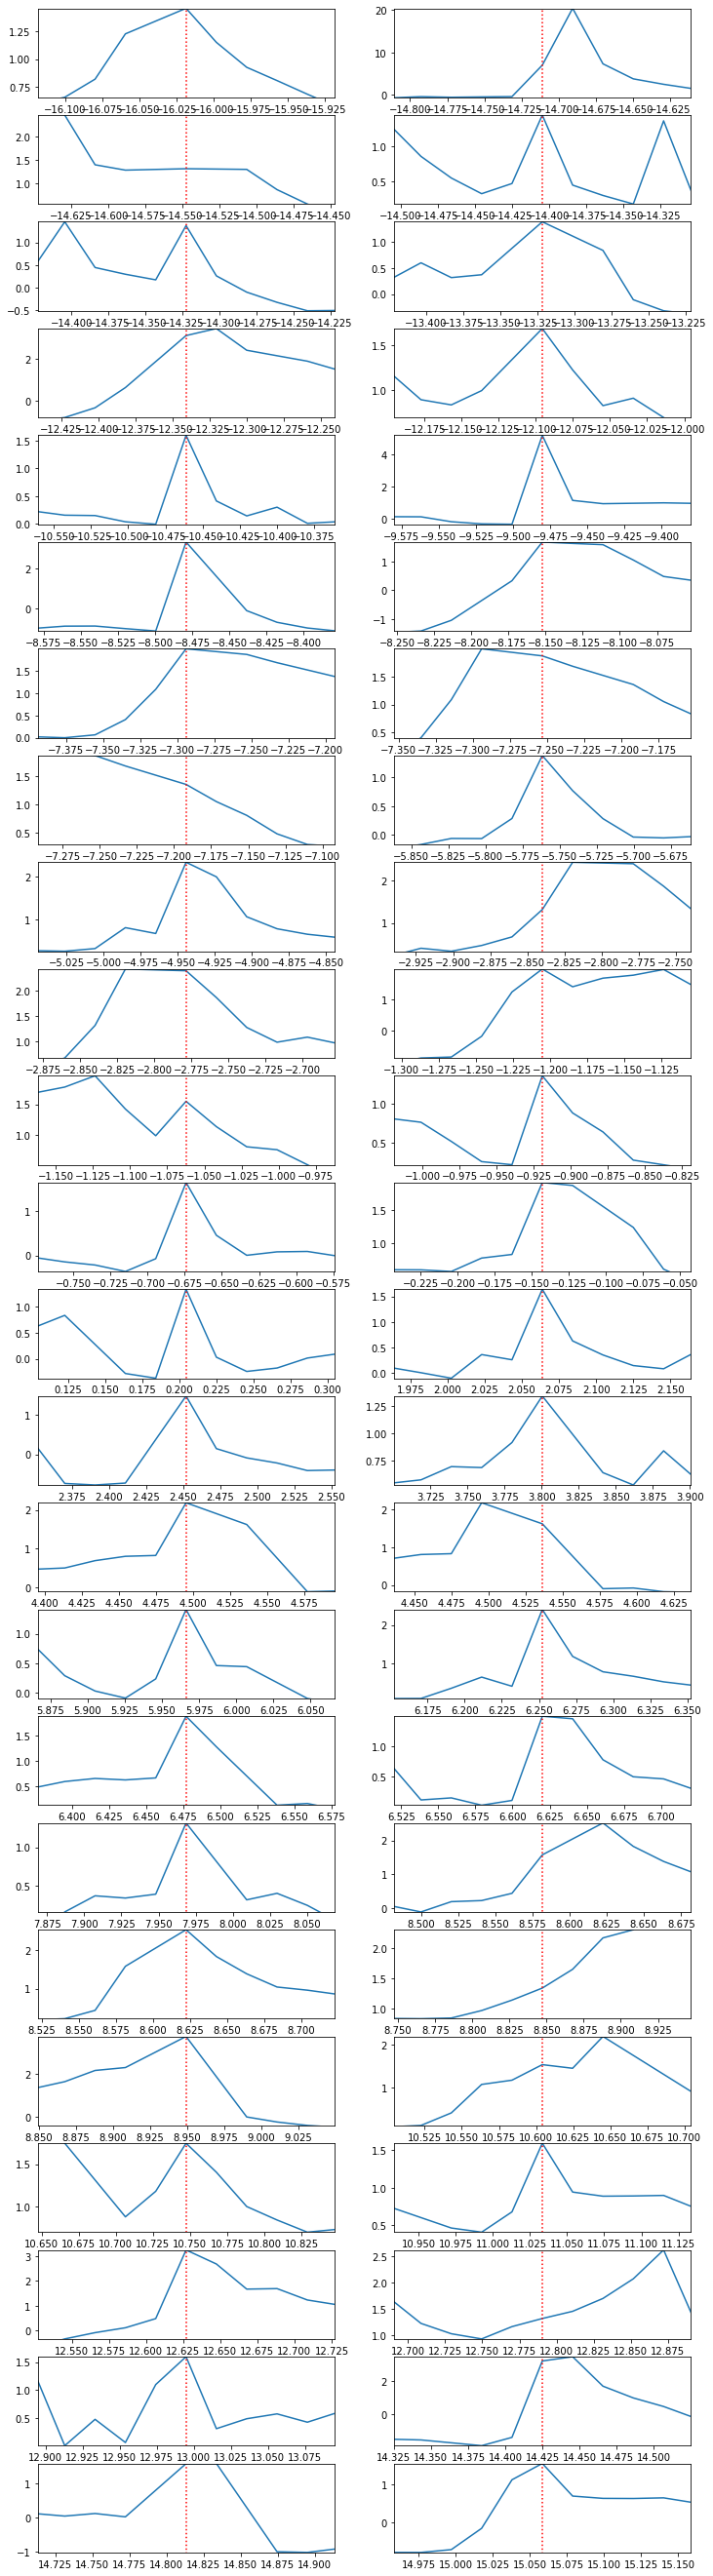

In [126]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_pre/2).astype(int), figsize=[12,npeaks_pre])
axes = axes.flatten()
for i in range(npeaks_pre):
    ax = axes[i]
    #ax.plot(x_pre, y_pre)
    detrended_pre = (norm_flux_pre - pred_pre)/np.std(norm_flux_pre - pred_pre)
    ax.plot(x_pre, detrended_pre) # norm_flux_pre
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_pre[i], -1, 1, color='r', linestyle=':')
    buffer = 0.1
    ax.set_xlim(tpeaks_norm_pre[i]-buffer, tpeaks_norm_pre[i]+buffer)
    snapshot = detrended_pre.loc[(x_pre > tpeaks_norm_pre[i]-buffer) & (x_pre < tpeaks_norm_pre[i]+buffer)] #- pd.Series(pred_pre).loc[(pd.Series(pred_pre) > tpeaks_norm_pre[i]-0.2) & (pd.Series(pred_pre) < tpeaks_norm_pre[i]+0.2)]
    ax.set_ylim(min(snapshot), max(snapshot))

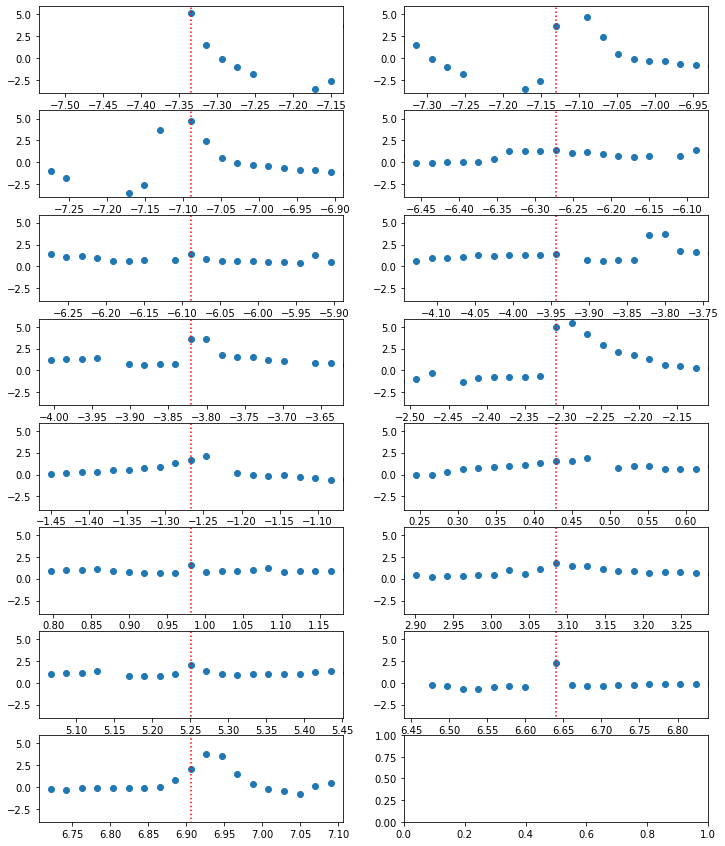

In [144]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_post/2).astype(int), figsize=[12,npeaks_post])
axes = axes.flatten()
for i in range(npeaks_post):
    ax = axes[i]
    ax.scatter(x_post, y_post)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_post[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_post[i]-0.2, tpeaks_norm_post[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

We can throw away the first identified flare because that's just the downslope of the super-flare. We can also combine the second and third identified flares because they're the same event. Why did they get double-counted, though?

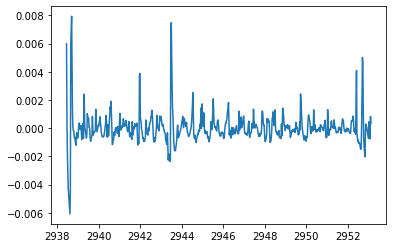

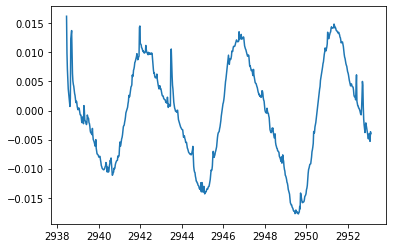

In [132]:
plt.plot(post.TIME, norm_flux_post - pred_post)
plt.show()

plt.plot(post.TIME, norm_flux_post)
plt.show()

In [149]:
print(tpeaks_post)
print(post.loc[(post.TIME < 2938.75) & (post.TIME > 2938.5)].TIME)

[2938.43605659 2938.64037271 2938.68123593 2939.49850037 2939.68238477
 2941.82770175 2941.95029121 2943.46222768 2944.5042374  2946.20005625
 2946.75170786 2948.85615609 2951.02189782 2952.41124125 2952.67685103]
1622    2938.517783
1626    2938.599509
1627    2938.619941
1628    2938.640373
1630    2938.681236
1631    2938.701668
1632    2938.722099
1633    2938.742531
Name: TIME, dtype: float64


Okay, I *think* it's because there's a gap in the data between index 1628 and 1630, and so the code that concatenates threshold events into the same event thinks they're not consecutive (and therefore belonging to the same event) after all.

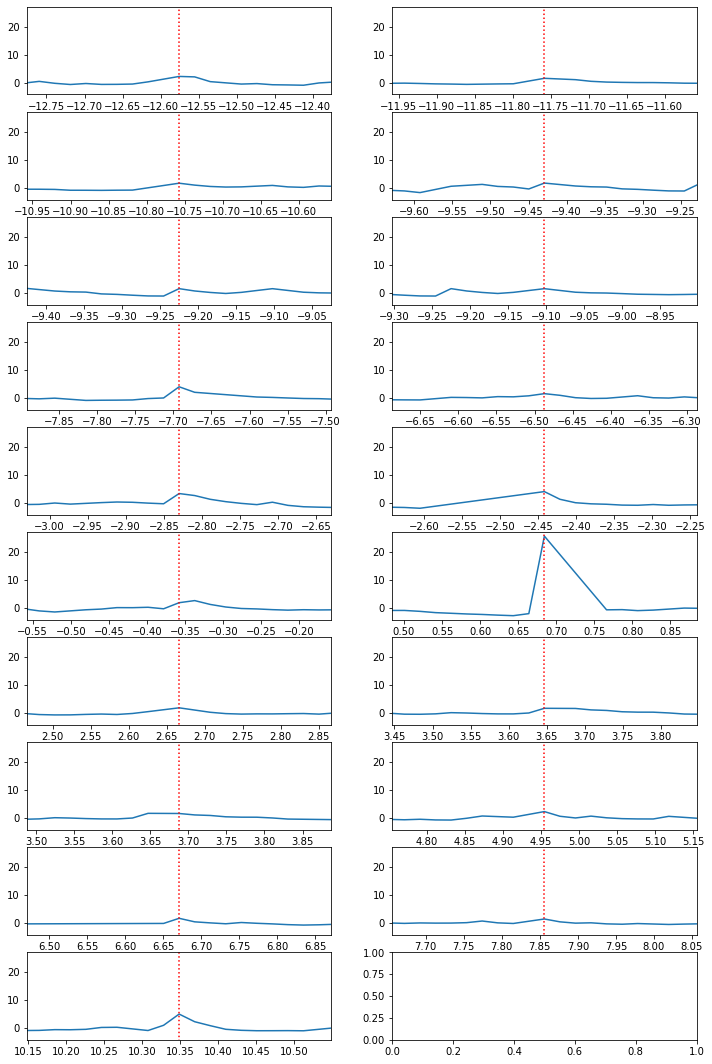

In [130]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_postgap/2).astype(int), figsize=[12,npeaks_postgap])
axes = axes.flatten()
for i in range(npeaks_postgap):
    ax = axes[i]
    ax.plot(x_postgap, y_postgap)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_postgap[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_postgap[i]-0.2, tpeaks_norm_postgap[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

### 8) Flare analysis: xoflares

I've output find_flares() to a csv and will read that in for flare energy and frequency distribution analysis in flare_analysis.ipynb.

### 9) Ancillary plots

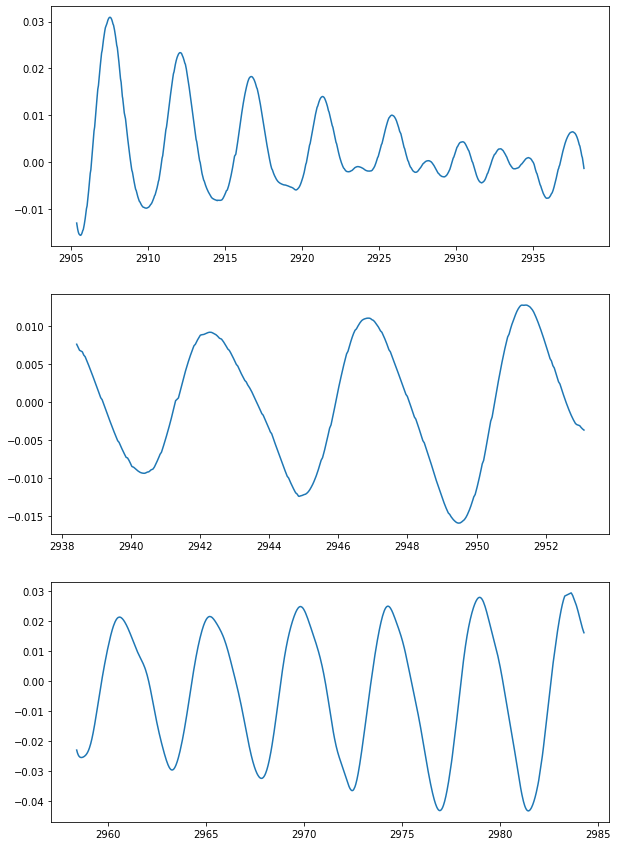

In [172]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, savgol_pre)

plt.subplot(312)
plt.plot(post.TIME, savgol_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

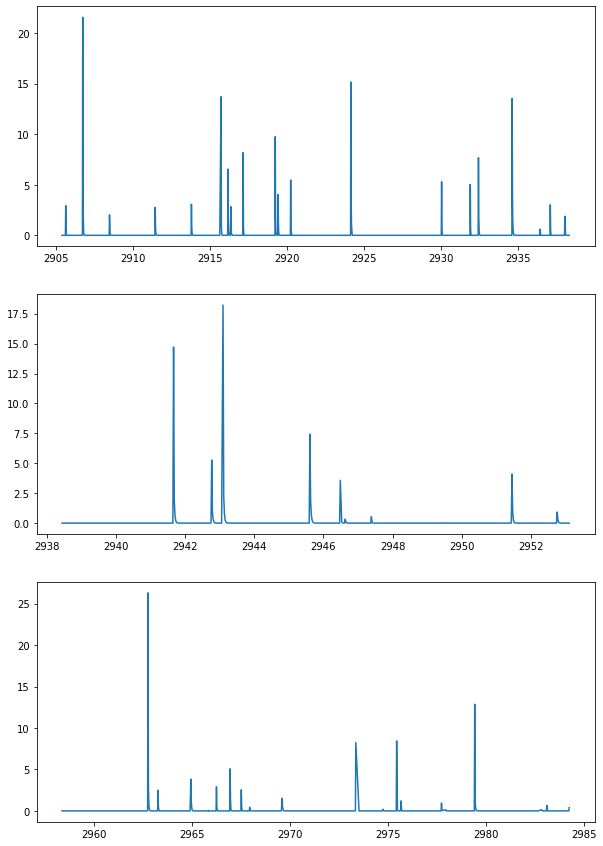

In [173]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))

plt.subplot(312)
plt.plot(post.TIME, (flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX))/np.std(flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX)))

plt.subplot(313)
plt.plot(postgap.TIME, (flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX))/np.std(flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX)))
plt.show()